# Bike Analysis and Demand Prediction for Washington, DC

![Capitol Hill, Washington, DC, USA](images/washington-dc.jpeg)

In [1]:
# Import packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import ml packages for preprocessing, model generation and metrics
from sklearn.linear_model import LinearRegression, RidgeCV, PoissonRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.stattools import adfuller

# options to display columns
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
sns.set_theme()
sns.set_palette('colorblind')

## EDA

We’ll start off by importing and loading the data into a data frame.

In [3]:
# Import data
dc_bikes = pd.read_csv('data/finaldata.csv', parse_dates=["date"])

The data is already clean and preprocessed, we have not missing values nor duplicates. Still, we’d like to add weather labels in order to visualize them later.

In [4]:
def labeling(awnd, prcp, snow, snwd):
    if prcp > 0.0:
        label = 'rain'
    elif snow > 0.0 or snwd > 0.0:
        label = 'snow'
    elif awnd >= 6.0:
        label = 'wind'
    else:
        label = 'sun'
    return label
    
dc_bikes['weather'] = dc_bikes.apply(lambda x: labeling(x.awnd, x.prcp, x.snow, x.snwd), axis=1)

### Visualizations

Next, we’ll have a look at the distribution of the data.


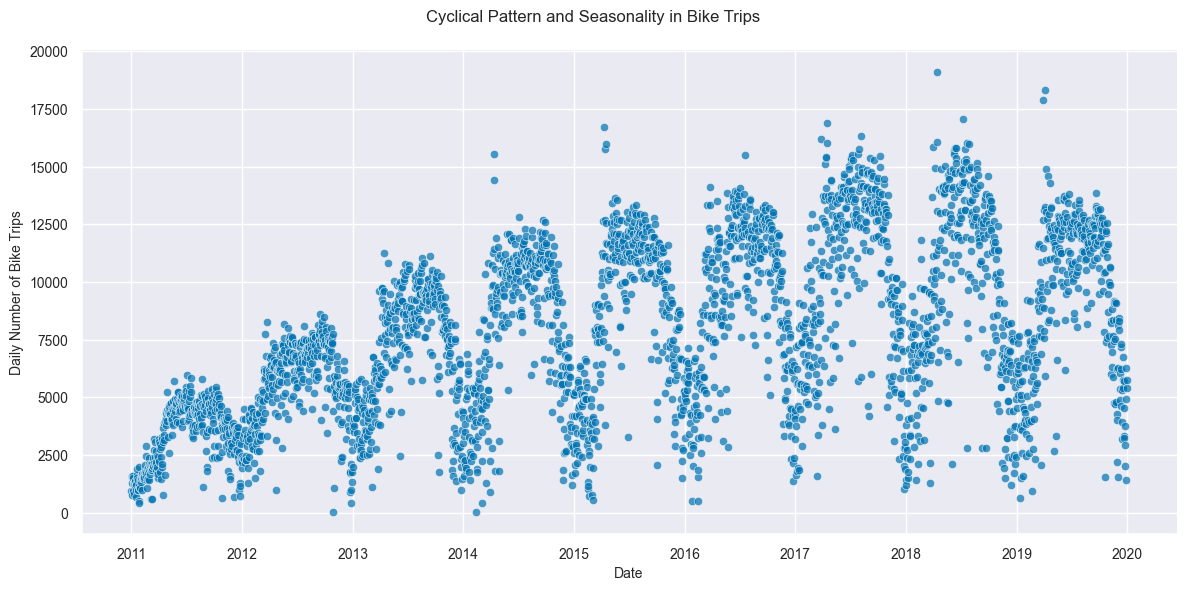

In [5]:
# Plot Number of Daily Bike Usage (2011-2019)
sns.relplot(
    data=dc_bikes,
    x='date',
    y='numbikes',
    height=6,
    aspect=2,
    #color='blue',
    alpha=.7)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Daily Number of Bike Trips', fontsize=10)
plt.suptitle('Cyclical Pattern and Seasonality in Bike Trips', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout(pad=1)
plt.show()
#plt.savefig('images/cyclical-patterns.png')

We can clearly make out the cyclical and seasonal nature of the data. Bike trips are taken a lot more during summertime and rentals die down in the fall and winter months. Also of note are regular peaks which seem to happen each year in April. Let’s have a look into what’s going on here.

In [6]:
dc_bikes.loc[list(dc_bikes.groupby('year').numbikes.idxmax()),['date','numbikes','tmax','weather']]

,date,numbikes,tmax,weather
184,2011-07-04,5975,32.8,sun
623,2012-09-15,8623,25.6,sun
833,2013-04-13,11267,21.1,sun
1197,2014-04-12,15564,25.0,sun
1561,2015-04-11,16746,20.0,sun
2020,2016-07-17,15526,33.9,sun
2292,2017-04-15,16896,25.0,sun
2656,2018-04-14,19113,29.4,sun
3017,2019-04-06,18346,21.7,sun


Except from Sep 2012 and July 2016, the peaks in demand fall in early to mid-April, which is when Washington’s Cherry Blossom Festival takes place.

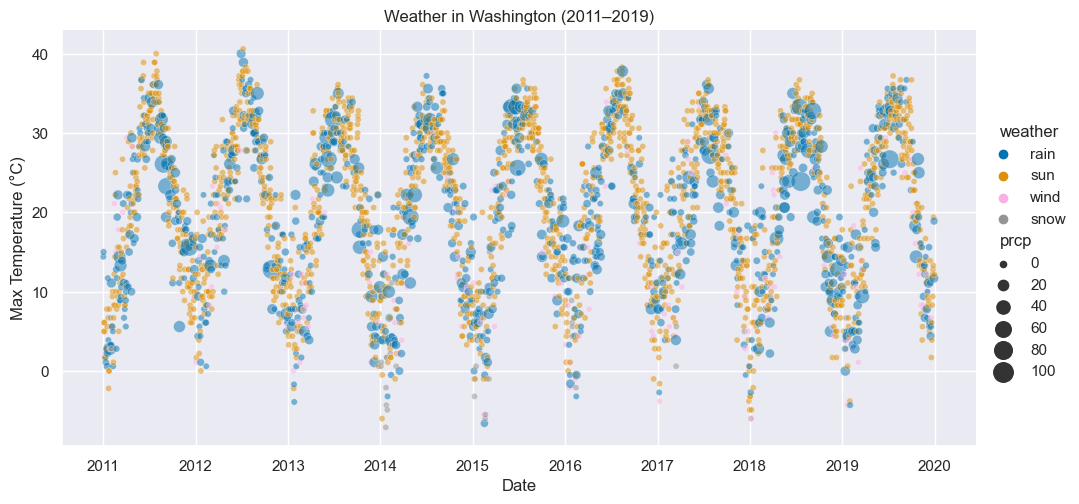

In [7]:
palette = {'sun':"#de8f05", 'wind':"#fbafe4", 'rain':'#0173b2', 'snow':"#949494"}

sns.relplot(
    data=dc_bikes,
    x="date", 
    y="tmax", 
    size="prcp", # set size of data points to amount of precipitation
    sizes=(20,200),
    hue='weather', 
    palette=palette,
    aspect=2,
    alpha=.5
)

plt.xlabel("Date")
plt.ylabel("Max Temperature (°C)")
plt.title("Weather in Washington (2011–2019)")

plt.show();

In [8]:
#ç.groupby('year').numbikes.mean().reset_index()

# Bike Trips by Year, Month, Week, Day of the Week 
avg_bikes_year = dc_bikes.groupby('year')['numbikes'].mean().reset_index()
avg_bikes_month = dc_bikes.groupby('month')['numbikes'].mean().reset_index()
avg_bikes_week = dc_bikes.groupby('week')['numbikes'].mean().reset_index()
avg_bikes_day = dc_bikes.groupby('dayofweek')['numbikes'].mean().reset_index()
avg_bikes_day = avg_bikes_day.rename({'dayofweek': 'day'}, axis=1)

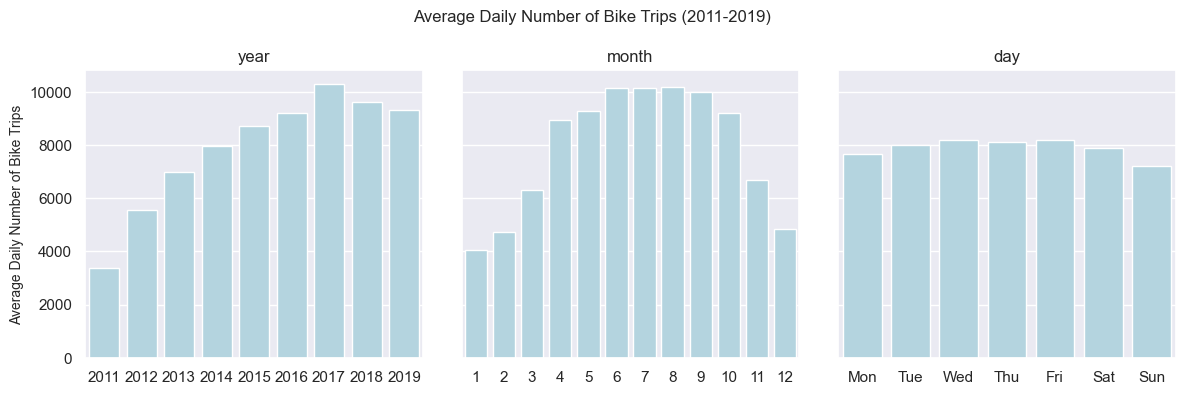

In [9]:
# Average Daily Number of Bike Trips by Year (2011-2019)
fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True)
fig.suptitle('Average Daily Number of Bike Trips (2011-2019)', fontsize=12)
avg_bikes_df = [avg_bikes_year, avg_bikes_month, avg_bikes_day]
count = 0
for item in avg_bikes_df:
    sns.barplot(data=item, 
                x=item.iloc[:,0],
                y='numbikes',
                ax=ax[count],
                color='lightblue').set(title=f'{item.columns[0]}', xlabel='')
    count += 1
fig.tight_layout(pad=1)

# Some axis customization on graph
ax[0].set_ylabel('Average Daily Number of Bike Trips', fontsize=10)
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[2].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.show()

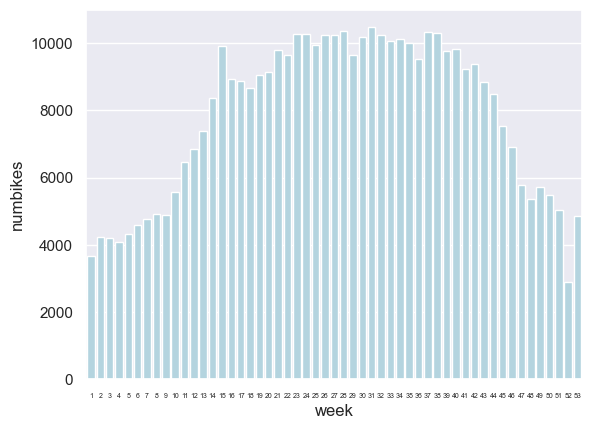

In [10]:
sns.barplot(
    data=avg_bikes_week,
    x="week",
    y="numbikes",
    color='lightblue'
    #palette=("Blues")
)
plt.xticks(fontsize=5)
plt.show();

Text(0.5, 1.0, 'Correlation Matrix for Weather Features')

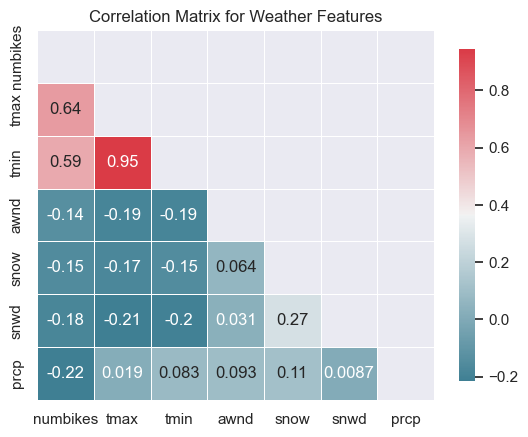

In [11]:
# checking for relationships among the features and between the features and the target
corr_mtrx = dc_bikes[['numbikes','tmax','tmin','awnd','snow','snwd','prcp']].corr()

mask = np.triu(corr_mtrx)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr_mtrx, annot=True, mask=mask, cmap=cmap, linewidths=.5, cbar_kws={"shrink": .9});
plt.title('Correlation Matrix for Weather Features')

In [12]:
dc_bikes.groupby('year').numbikes.mean()

year
2011     3361.005479
2012     5543.472678
2013     7001.482192
2014     7981.232877
2015     8728.509589
2016     9209.928177
2017    10295.279452
2018     9600.769648
2019     9310.731507
Name: numbikes, dtype: float64

## Creating Models

Before we can start creating and running the models, we‘ll specify our features, i.e. calendar events and weather features. 

In [26]:
# define list of features for regression analysis
calendar_features = [f'dow_{i+1}' for i in range(0,6)] + \
                    [f'month_{i+1}' for i in range(1,12)] + \
                    [f'year_{i+1}' for i in range(2011,2018)] + \
                    ['sin_doy', 'cos_doy', 'sin_dow', 'cos_dow', 'holiday']
weather_features = ['awnd_log', 'prcp_log', 'snow_log',	'snwd_log', 'tmax', 'tmin']
all_features = [*calendar_features, *weather_features]

To make our lives a bit easier and not lose overview, let’s put all the steps required for a model to run into a function.

In [27]:
# define function to train/test model and produce error analysis
def reg_predict(
    df,
    features,
    train_year_end = 2018, # training year from 2011 up until year specified here
    test_year = 2019, # test year must be after train_year_end, must be between 2011 and 2019
    model = 'Linear', # choice of 'Linear', 'Polynomial', 'Ridge', 'Poisson'
    scaling = True, # default scaling (standardization) of x variables
    logbikes = False, # default y variable is not log transformed
    degree = 2, # quadratic polynomial is default for polynomial and ridge regression
    alphas = [0.01,0.1,1,10,100], # regularization grid for ridge regression
    n_estimators = 550, # number of estimators for xgboost regression
    max_features = 'sqrt' # maximum number of features for random forest
):

    ### regression analysis ###

    # define train/test years
    df_train = df[df['year'] <= train_year_end]
    df_test = df[df['year'] == test_year]

    # define X, y for train/test sample
    X_train = df_train[features]
    X_test = df_test[features]
    y_train = df_train['numbikes']
    y_test = df_test['numbikes']

    # scaling standardization for features
    if scaling:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    # log choice for number of bikes
    if logbikes:
        y_train = np.log(y_train)
        y_test = np.log(y_test)
    
    # choice for regression models
    if model == 'Linear':
        regr = LinearRegression()
    elif model == 'Polynomial':
        regr = make_pipeline(
            PolynomialFeatures(degree=degree),
            LinearRegression()
            )
    elif model == 'Ridge':
        regr = make_pipeline(
            PolynomialFeatures(degree=degree),
            RidgeCV(alphas=alphas)
            )
    elif model == 'Poisson':
        regr = PoissonRegressor()
    elif model == 'XGBoost':
        regr = XGBRegressor(n_estimators=n_estimators)
    elif model == 'Random Forest':
        regr = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features)
    else:
        assert False, f'Unknown model {model}'
    
    # fitting and prediction
    regr.fit(X_train, y_train)
    y_pred_train = regr.predict(X_train)
    y_pred = regr.predict(X_test)

    # print mape for train/test of model
    print('----------------------------------')
    print(f'{model} regression')
    print(f'Training Period: 2011-{train_year_end}')
    print(f'Test Period: {test_year}')
    print('----------------------------------')
    print(f'Train MAPE: {mean_absolute_percentage_error(y_train, y_pred_train).round(3)}')
    print(f'Test MAPE: {mean_absolute_percentage_error(y_test, y_pred).round(3)}')
    print('----------------------------------')

    ### residuals analysis ###

    # define residuals and subplots
    residuals_test = y_test - y_pred
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    fig.suptitle(f'Residual Analysis: Test Period {test_year}', fontsize=12)

    # plot distribution of residuals
    plot_0 = sns.histplot(residuals_test, ax=ax[0], color='Blue')
    plot_0.grid(False)
    ax[0].set_xlabel('Residuals', fontsize=10)
    ax[0].set_ylabel('')
    
    # plot residuals vs predicted
    plot_1 = sns.scatterplot(x=y_pred, y=residuals_test, ax=ax[1], color='Blue')
    plot_1.grid(False)
    ax[1].set_xlabel('Predicted', fontsize=10)
    ax[1].set_ylabel('Residual', fontsize=10)
    plt.show()
    
    # augmented dickey-fuller test for stationarity of residuals #
    print('ADF Test for Residual Stationarity')
    result = adfuller(residuals_test)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
	    print('\t%s: %.3f' % (key, value))
    print('----------------------------------')

----------------------------------
Linear regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.474
Test MAPE: 0.693
----------------------------------


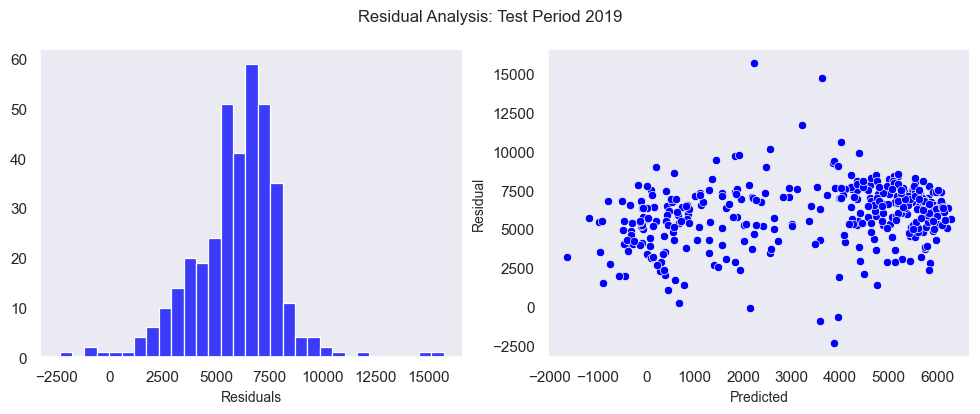

ADF Test for Residual Stationarity
ADF Statistic: -2.583763
p-value: 0.096400
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
----------------------------------


In [17]:
# baseline model 
reg_predict(df=bikes, features=calendar_features)

----------------------------------
Linear regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.029
Test MAPE: 0.115
----------------------------------


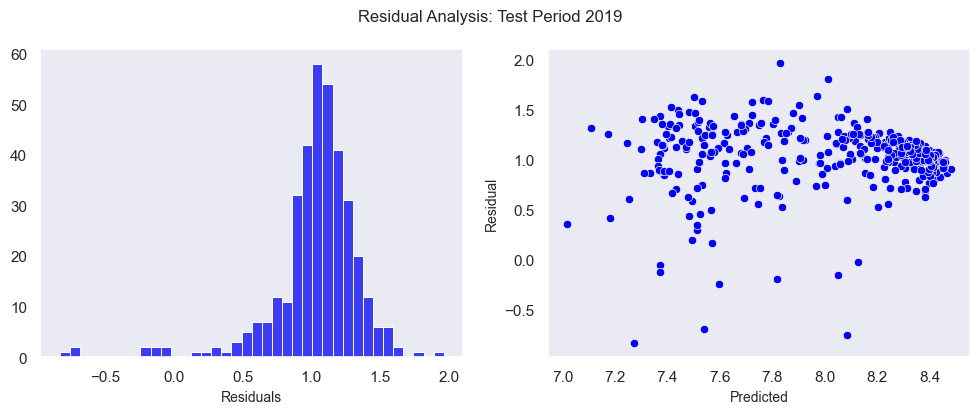

ADF Test for Residual Stationarity
ADF Statistic: -14.514037
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
----------------------------------


In [18]:
# use logbikes on baseline model
reg_predict(df=bikes, features=calendar_features, logbikes=True)

----------------------------------
Polynomial regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.025
Test MAPE: 0.116
----------------------------------


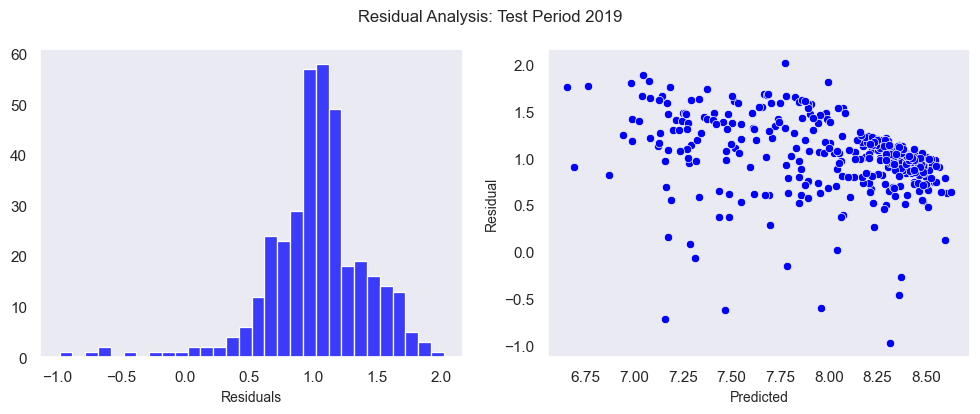

ADF Test for Residual Stationarity
ADF Statistic: -4.160854
p-value: 0.000767
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
----------------------------------


In [19]:
# use logbikes and polynomial regression degree 2
reg_predict(df=bikes, features=calendar_features, logbikes=True, model='Polynomial')

----------------------------------
Ridge regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.025
Test MAPE: 0.116
----------------------------------


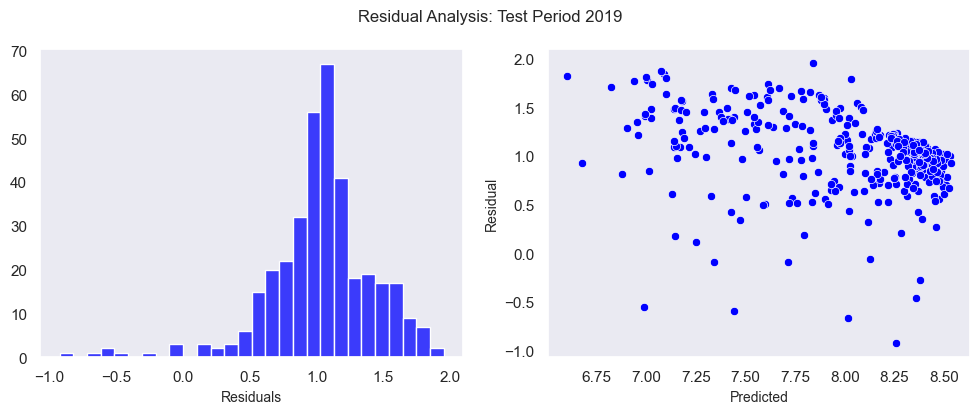

ADF Test for Residual Stationarity
ADF Statistic: -3.487229
p-value: 0.008321
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
----------------------------------


In [20]:
# use logbikes and ridge regression
reg_predict(df=bikes, features=calendar_features, logbikes=True, model='Ridge')

----------------------------------
Poisson regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.033
Test MAPE: 0.08
----------------------------------


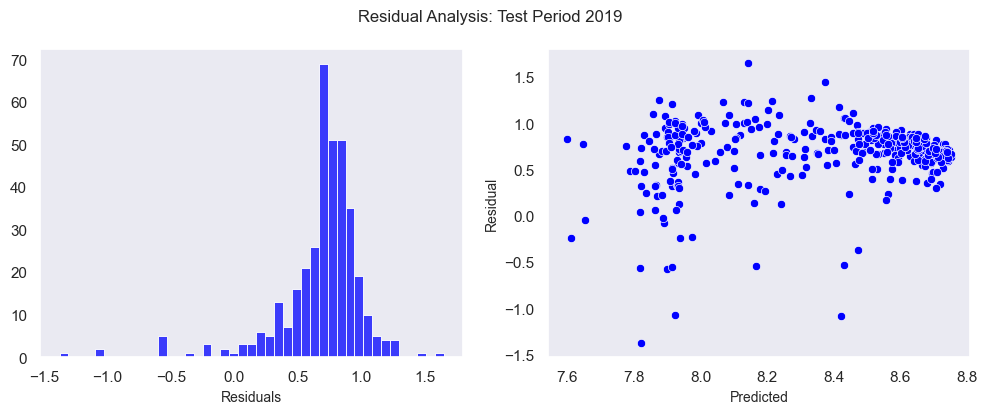

ADF Test for Residual Stationarity
ADF Statistic: -3.923940
p-value: 0.001866
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
----------------------------------


In [21]:
# use logbikes and poisson regression
reg_predict(df=bikes, features=calendar_features, logbikes=True, model='Poisson')

----------------------------------
Linear regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.021
Test MAPE: 0.114
----------------------------------


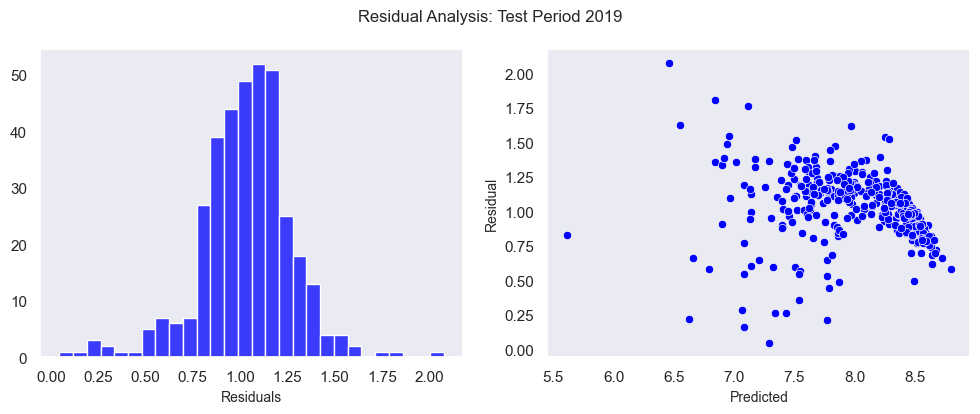

ADF Test for Residual Stationarity
ADF Statistic: -9.554721
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
----------------------------------


In [22]:
# use logbike with weather and calendar features
reg_predict(df=bikes, features=all_features, logbikes=True)

----------------------------------
Poisson regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.025
Test MAPE: 0.076
----------------------------------


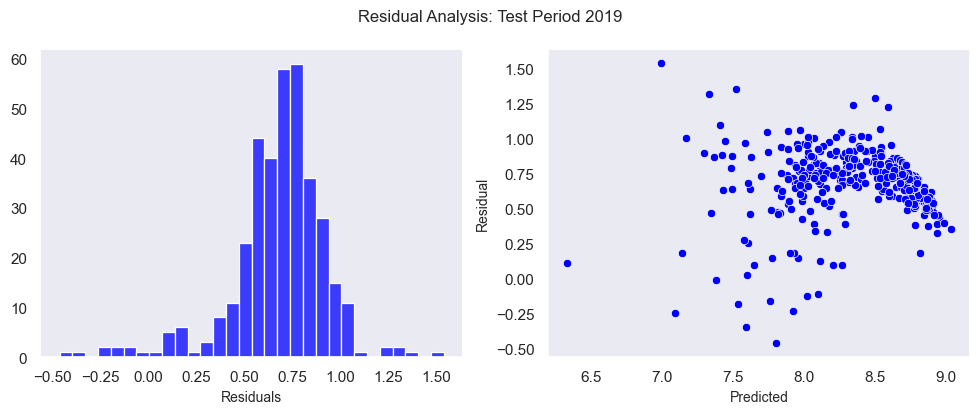

ADF Test for Residual Stationarity
ADF Statistic: -8.460738
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
----------------------------------


In [23]:
# use logbike with weather and calendar features; poisson regression
reg_predict(df=bikes, features=all_features, logbikes=True, model='Poisson')

----------------------------------
XGBoost regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.0
Test MAPE: 0.105
----------------------------------


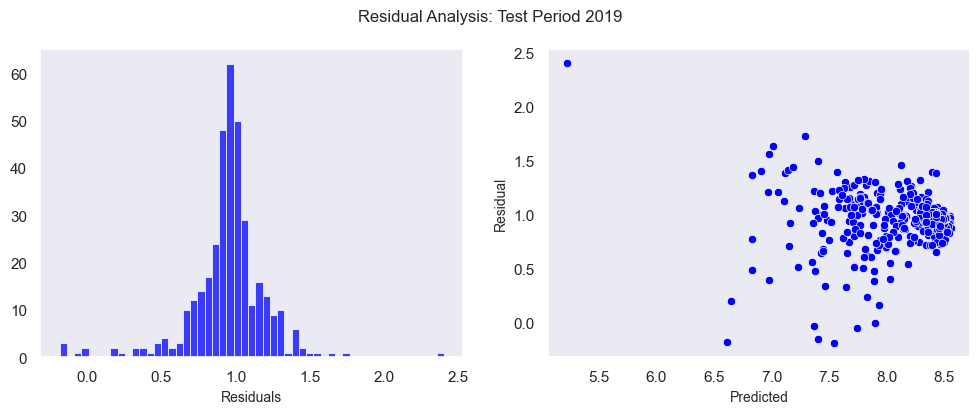

ADF Test for Residual Stationarity
ADF Statistic: -1.986800
p-value: 0.292390
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
----------------------------------


In [24]:
reg_predict(df=bikes, features=all_features, model='XGBoost', logbikes=True)

----------------------------------
Random Forest regression
Training Period: 2011-2018
Test Period: 2019
----------------------------------
Train MAPE: 0.01
Test MAPE: 0.056
----------------------------------


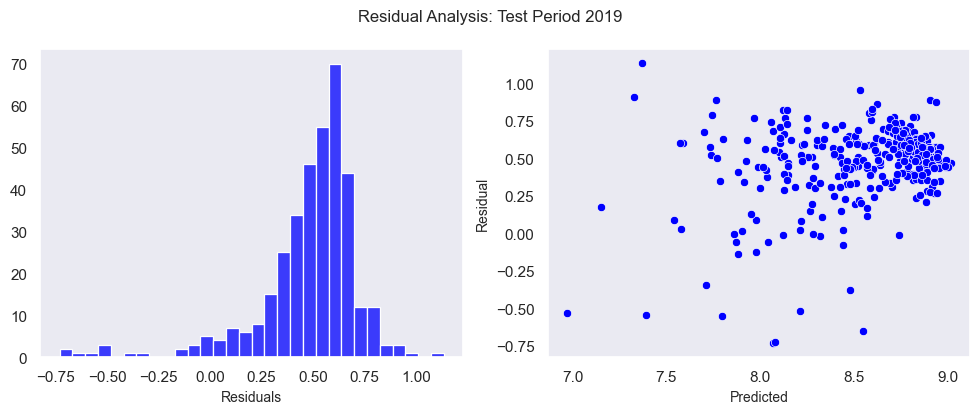

ADF Test for Residual Stationarity
ADF Statistic: -2.775757
p-value: 0.061821
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
----------------------------------


In [25]:
reg_predict(df=bikes, features=all_features, model='Random Forest', logbikes=True)